<a href="https://colab.research.google.com/github/AsyrofiAnam/Data-Mining/blob/main/Clustering_Gempa_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLUSTERING GEMPA INDONESIA BIRCH & DBSCAN

#IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

#LOAD & FILTER DATA GEMPA INDONESIA

In [2]:
# Load data
data = pd.read_csv("gempa_indonesia.csv")
print(f"Jumlah data awal: {len(data)}")

# Cek dan drop missing di fitur utama
fitur = ['Latitude', 'Longitude', 'Depth', 'Magnitude']
data = data.dropna(subset=fitur)
print(f"Jumlah data setelah drop NA: {len(data)}")

# Filter data wilayah Indonesia
data = data[data['Region name'].str.lower().str.contains("indonesia", na=False)].reset_index(drop=True)
print(f"Jumlah data setelah filter 'Region name' mengandung 'indonesia': {len(data)}")

# Tampilkan 5 baris pertama sebagai preview
data.head()

Jumlah data awal: 6654
Jumlah data setelah drop NA: 6654
Jumlah data setelah filter 'Region name' mengandung 'indonesia': 5516


,Date,Time (UTC),Latitude,Longitude,Region name,Depth,Magnitude Type,Magnitude,EqId
0,7/8/2025,17:02:42,-8.64,118.41,"SUMBAWA REGION, INDONESIA",98.0,m,4.1,20250708_0000178
1,7/8/2025,16:37:51,-1.02,137.25,"NEAR N COAST OF PAPUA, INDONESIA",98.0,m,4.4,20250708_0000174
2,7/8/2025,14:10:37,-2.20,127.71,"CERAM SEA, INDONESIA",13.0,m,3.7,20250708_0000144
3,7/8/2025,13:33:02,-5.61,121.81,"SULAWESI, INDONESIA",10.0,m,2.8,20250708_0000134
4,7/8/2025,12:22:55,2.60,128.32,"HALMAHERA, INDONESIA",16.0,m,3.3,20250708_0000122


# PAIRPLOT

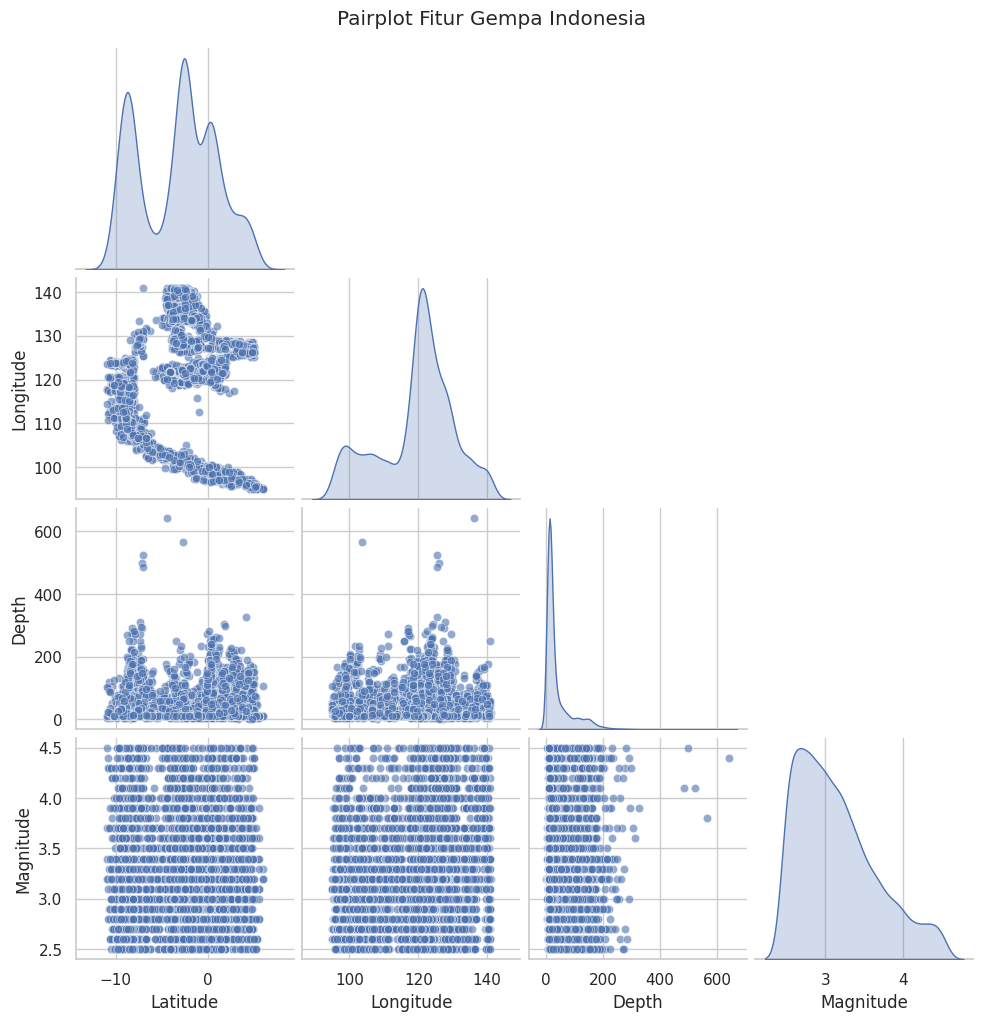

In [3]:
# Pastikan kolom tersedia dan tidak ada missing values
features = ['Latitude', 'Longitude', 'Depth', 'Magnitude']
data_pair = data[features].dropna()

sns.pairplot(data_pair, diag_kind='kde', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot Fitur Gempa Indonesia", y=1.02)
plt.show()

# KORELASI

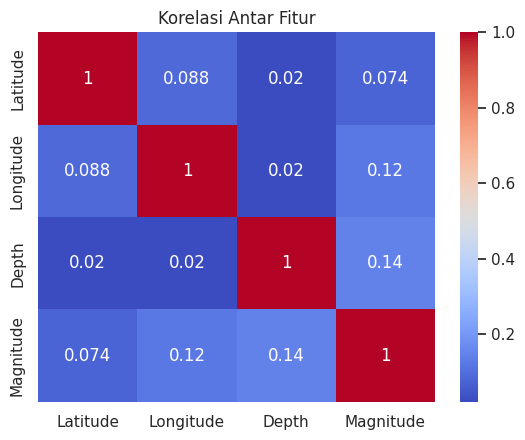

In [4]:
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

# Binning Lokasi menjadi Grid

In [5]:
# Binning lokasi untuk grid (derajat 1x1)
data['lat_bin'] = data['Latitude'].round(1)   # grid 0.1 derajat latitude
data['lon_bin'] = data['Longitude'].round(1)  # grid 0.1 derajat longitude

# Hitung Frekuensi dan Mean Magnitudo per Grid

In [6]:
# Hitung frekuensi dan rata-rata magnitudo per grid
grid_stats = data.groupby(['lat_bin', 'lon_bin']).agg(
    frequency=('Latitude', 'size'),
    mean_magnitude=('Magnitude', 'mean'),
    mean_depth=('Depth', 'mean')
).reset_index()

print("\nContoh grid stats:")
print(grid_stats.head())


Contoh grid stats:
   lat_bin  lon_bin  frequency  mean_magnitude  mean_depth
0    -11.0    117.8          1             3.7        10.0
1    -10.9    114.4          1             4.5        10.0
2    -10.9    117.7          1             3.4         5.0
3    -10.9    123.6          1             3.2       104.0
4    -10.8    110.9          1             4.4        23.0


#PREPROCESSING & PCA

In [7]:
# --- Clustering berdasarkan frekuensi dan rata-rata magnitudo
features = ['frequency', 'mean_magnitude', 'mean_depth']
X = grid_stats[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#EVALUASI CLUSTERING FUNCTION

In [8]:
# Evaluasi fungsi clustering
def evaluate_clustering(X_scaled, labels, name):
    if len(set(labels)) > 1:
        s = silhouette_score(X_scaled, labels)
        d = davies_bouldin_score(X_scaled, labels)
        c = calinski_harabasz_score(X_scaled, labels)
        print(f"\n{name} Evaluation:")
        print(f"Silhouette Score        : {s:.4f}")
        print(f"Davies-Bouldin Index    : {d:.4f}")
        print(f"Calinski-Harabasz Score : {c:.4f}")
        return s, d, c
    else:
        print(f"\n{name} menghasilkan hanya 1 cluster atau semua noise.")
        return None, None, None

# CLUSTERING: BIRCH

Evaluasi Birch Clustering (k = 2 sampai 5):

k=2 | Silhouette: 0.8910 | DB Index: 0.3580 | CH Score: 1009.83
k=3 | Silhouette: 0.6008 | DB Index: 0.5542 | CH Score: 899.02
k=4 | Silhouette: 0.6004 | DB Index: 0.6137 | CH Score: 646.28
k=5 | Silhouette: 0.5604 | DB Index: 0.6035 | CH Score: 555.69


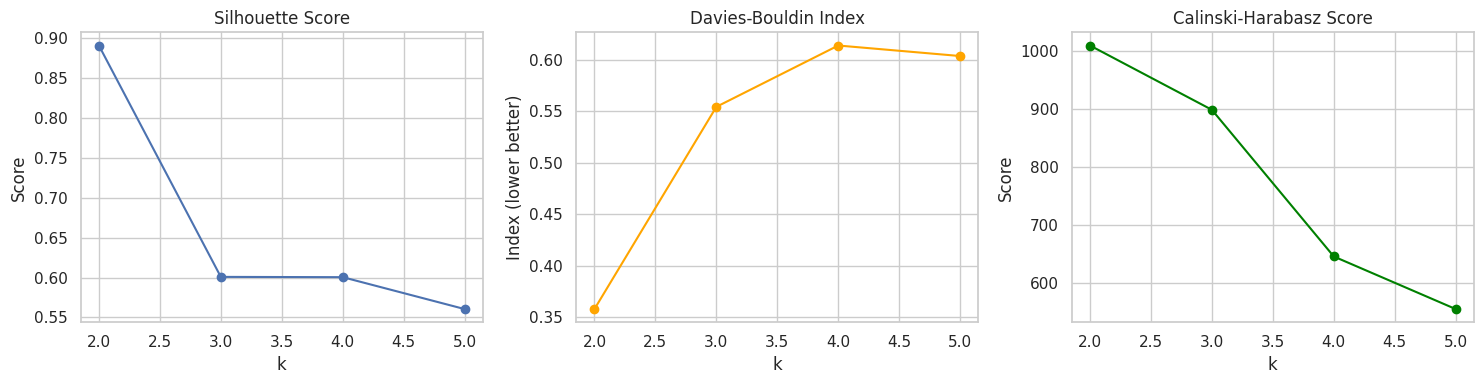

In [9]:
def evaluate_birch_k2_to_k5(X_scaled, k_range=range(2, 6)):
    silhouette_scores = []
    db_scores = []
    ch_scores = []

    print("Evaluasi Birch Clustering (k = 2 sampai 5):\n")
    for k in k_range:
        model = Birch(n_clusters=k)
        labels = model.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)

        silhouette_scores.append(sil)
        db_scores.append(db)
        ch_scores.append(ch)

        print(f"k={k} | Silhouette: {sil:.4f} | DB Index: {db:.4f} | CH Score: {ch:.2f}")

    # Plot hasil evaluasi
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.subplot(1, 3, 2)
    plt.plot(k_range, db_scores, marker='o', color='orange')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('k')
    plt.ylabel('Index (lower better)')

    plt.subplot(1, 3, 3)
    plt.plot(k_range, ch_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('k')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Jalankan fungsi
evaluate_birch_k2_to_k5(X_scaled)

# CLUSTERING: DBSCAN

Evaluating DBSCAN for different eps values...

eps=0.50 | Clusters: 3 | Noise: 55 (1.72%) | Silhouette: 0.5671 | DB Index: 1.5982 | CH Score: 166.16
eps=2.10 | Clusters: 2 | Noise: 9 (0.28%) | Silhouette: 0.8120 | DB Index: 0.3352 | CH Score: 643.62
eps=2.30 | Clusters: 2 | Noise: 9 (0.28%) | Silhouette: 0.8120 | DB Index: 0.3352 | CH Score: 643.62
eps=2.50 | Clusters: 2 | Noise: 9 (0.28%) | Silhouette: 0.8120 | DB Index: 0.3352 | CH Score: 643.62
eps=2.70 | Clusters: 2 | Noise: 9 (0.28%) | Silhouette: 0.8120 | DB Index: 0.3352 | CH Score: 643.62
eps=2.90 | Clusters: 2 | Noise: 9 (0.28%) | Silhouette: 0.8120 | DB Index: 0.3352 | CH Score: 643.62
eps=3.10 | Clusters: 2 | Noise: 4 (0.12%) | Silhouette: 0.8850 | DB Index: 4.2165 | CH Score: 506.31
eps=3.30 | Clusters: 2 | Noise: 2 (0.06%) | Silhouette: 0.8726 | DB Index: 0.5017 | CH Score: 554.37
eps=3.50 | Clusters: 2 | Noise: 2 (0.06%) | Silhouette: 0.8726 | DB Index: 0.5017 | CH Score: 554.37
eps=3.70 | Clusters: 2 | Noise: 2 (0.06%) |

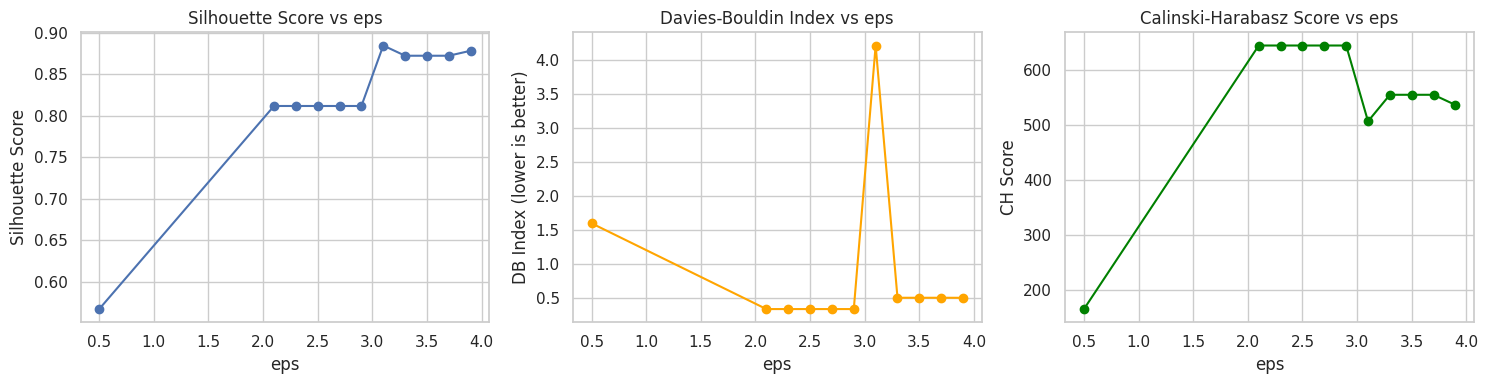

In [10]:
def find_best_eps_dbscan(X_scaled, eps_values=np.arange(0.1, 5.0, 0.2), min_samples=5, max_noise_ratio=0.05):
    results = []

    print("Evaluating DBSCAN for different eps values...\n")
    n_samples = len(X_scaled)

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Hitung jumlah cluster (exclude noise = -1)
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / n_samples

        # Skip jika cluster kurang dari 2 atau noise terlalu banyak
        if n_clusters < 2 or noise_ratio > max_noise_ratio:
            continue

        sil_score = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)

        results.append((eps, sil_score, db_score, ch_score, n_clusters, n_noise))

        print(f"eps={eps:.2f} | Clusters: {n_clusters} | Noise: {n_noise} ({noise_ratio:.2%}) | Silhouette: {sil_score:.4f} | DB Index: {db_score:.4f} | CH Score: {ch_score:.2f}")

    if len(results) == 0:
        print("\nTidak ada konfigurasi eps yang menghasilkan >=2 cluster dengan noise <= 5%.")
        return

    results = np.array(results)
    best_idx = np.argmax(results[:, 1])  # Maksimalkan Silhouette Score
    best_eps = results[best_idx, 0]

    print(f"\n🟢 Epsilon terbaik (berdasarkan Silhouette Score dan kriteria cluster & noise): {best_eps:.2f}")

    # Plot hasil
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(results[:, 0], results[:, 1], marker='o')
    plt.title('Silhouette Score vs eps')
    plt.xlabel('eps')
    plt.ylabel('Silhouette Score')

    plt.subplot(1, 3, 2)
    plt.plot(results[:, 0], results[:, 2], marker='o', color='orange')
    plt.title('Davies-Bouldin Index vs eps')
    plt.xlabel('eps')
    plt.ylabel('DB Index (lower is better)')

    plt.subplot(1, 3, 3)
    plt.plot(results[:, 0], results[:, 3], marker='o', color='green')
    plt.title('Calinski-Harabasz Score vs eps')
    plt.xlabel('eps')
    plt.ylabel('CH Score')

    plt.tight_layout()
    plt.show()

# Panggil fungsi dengan parameter default
find_best_eps_dbscan(X_scaled, eps_values=np.arange(0.1, 5.0, 0.2), min_samples=5)

# BIRCH DENGAN K=2

In [11]:
birch_model = Birch(n_clusters=2)
labels_birch = birch_model.fit_predict(X_scaled)
evaluate_clustering(X_scaled, labels_birch, "Birch (k=2)")


Birch (k=2) Evaluation:
Silhouette Score        : 0.8910
Davies-Bouldin Index    : 0.3580
Calinski-Harabasz Score : 1009.8279


(np.float64(0.8909520619476275),
 np.float64(0.35804448588525717),
 np.float64(1009.8279329989018))

# DBSCAN (eps=3.10)

In [12]:
dbscan_model = DBSCAN(eps=3.10, min_samples=5)
labels_dbscan = dbscan_model.fit_predict(X_scaled)
evaluate_clustering(X_scaled, labels_dbscan, "DBSCAN")


DBSCAN Evaluation:
Silhouette Score        : 0.8850
Davies-Bouldin Index    : 4.2165
Calinski-Harabasz Score : 506.3128


(np.float64(0.8849554195176033),
 np.float64(4.216498142169623),
 np.float64(506.3127677038527))

# ANALISIS DATA

In [13]:
def assign_risk_label(df, labels, model_name):
    df[f'Cluster_{model_name}'] = labels

    # Hitung rata-rata jumlah kejadian per cluster
    cluster_means = df.groupby(f'Cluster_{model_name}')['frequency'].mean().sort_values(ascending=False)

    # Cluster dengan rata-rata frekuensi tertinggi dianggap 'Rawan'
    cluster_map = {cluster: ('Rawan' if i == 0 else 'Tidak Rawan') for i, cluster in enumerate(cluster_means.index)}

    # Mapping ke label risiko
    df[f'Risk_{model_name}'] = df[f'Cluster_{model_name}'].map(cluster_map)
    return df

In [14]:
grid_stats = assign_risk_label(grid_stats, labels_birch, "Birch")
grid_stats = assign_risk_label(grid_stats, labels_dbscan, "DBSCAN")

In [15]:
# Merge hasil clustering dari grid ke data asli
data = data.merge(grid_stats[['lat_bin', 'lon_bin', 'Cluster_Birch', 'Risk_Birch']],
                  on=['lat_bin', 'lon_bin'], how='left')

data = data.drop(columns=['Cluster_DBSCAN', 'Risk_DBSCAN'], errors='ignore')  # optional
dbscan_merge = grid_stats[['lat_bin', 'lon_bin', 'Cluster_DBSCAN', 'Risk_DBSCAN']].drop_duplicates()
data = data.merge(dbscan_merge, on=['lat_bin', 'lon_bin'], how='left')

In [16]:
# Lihat contoh hasil
print("\n✅ Contoh hasil label risiko (Birch vs DBSCAN):")
print(data[['Latitude', 'Longitude', 'Magnitude', 'Depth',
            'Cluster_Birch', 'Risk_Birch', 'Cluster_DBSCAN', 'Risk_DBSCAN']].head())


✅ Contoh hasil label risiko (Birch vs DBSCAN):
   Latitude  Longitude  Magnitude  Depth  Cluster_Birch   Risk_Birch  \
0     -8.64     118.41        4.1   98.0              0  Tidak Rawan   
1     -1.02     137.25        4.4   98.0              0  Tidak Rawan   
2     -2.20     127.71        3.7   13.0              0  Tidak Rawan   
3     -5.61     121.81        2.8   10.0              0  Tidak Rawan   
4      2.60     128.32        3.3   16.0              0  Tidak Rawan   

   Cluster_DBSCAN  Risk_DBSCAN  
0               0  Tidak Rawan  
1               0  Tidak Rawan  
2               0  Tidak Rawan  
3               0  Tidak Rawan  
4               0  Tidak Rawan  


In [17]:
def summarize_clusters(data, cluster_col):
    return data.groupby(cluster_col).agg({
        'Magnitude': 'mean',
        'Depth': 'mean',
        'Latitude': 'count'
    }).rename(columns={'Latitude': 'Count'})

print("\n📊 Statistik Cluster Birch:")
print(summarize_clusters(data, 'Cluster_Birch'))

print("\n📊 Statistik Cluster DBSCAN:")
print(summarize_clusters(data[data['Cluster_DBSCAN'] != -1], 'Cluster_DBSCAN'))


📊 Statistik Cluster Birch:
               Magnitude      Depth  Count
Cluster_Birch                             
0               3.159693  40.418367   5009
1               3.040434   9.652860    507

📊 Statistik Cluster DBSCAN:
                Magnitude      Depth  Count
Cluster_DBSCAN                             
0                3.159693  40.418367   5009
1                3.066667   9.618519    270


# VISUALISASI PCA

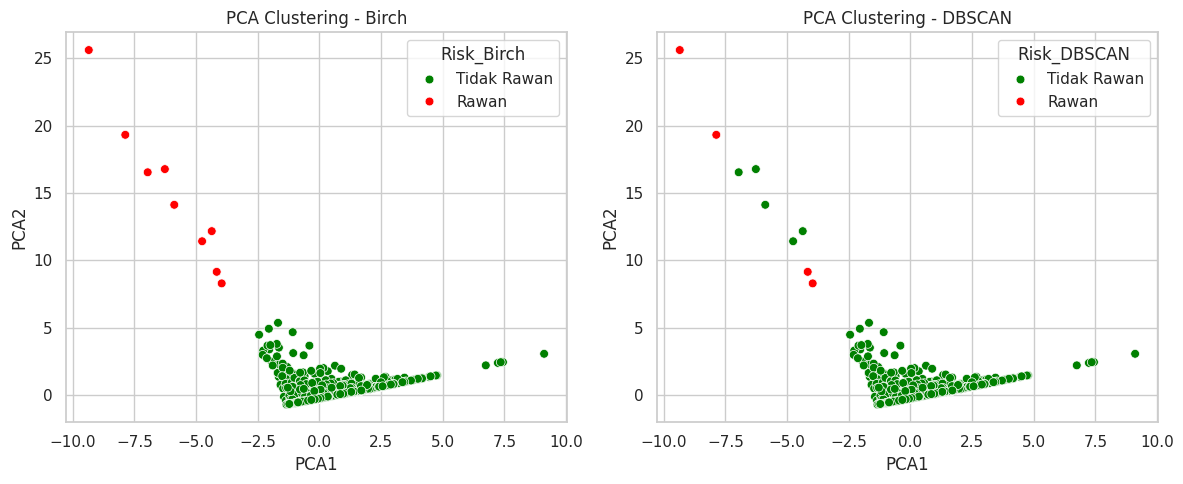

In [18]:
from sklearn.decomposition import PCA

# PCA 2D untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Tambahkan hasil PCA ke grid_stats
grid_stats['PCA1'] = X_pca[:, 0]
grid_stats['PCA2'] = X_pca[:, 1]

# Visualisasi PCA hasil clustering
plt.figure(figsize=(12, 5))

# Birch
plt.subplot(1, 2, 1)
sns.scatterplot(data=grid_stats, x='PCA1', y='PCA2', hue='Risk_Birch',
                palette={'Rawan': 'red', 'Tidak Rawan': 'green'}, s=40)
plt.title("PCA Clustering - Birch")
plt.grid(True)

# DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=grid_stats, x='PCA1', y='PCA2', hue='Risk_DBSCAN',
                palette={'Rawan': 'red', 'Tidak Rawan': 'green'}, s=40)
plt.title("PCA Clustering - DBSCAN")
plt.grid(True)

plt.tight_layout()
plt.show()

#VISUALISASI MAPPING

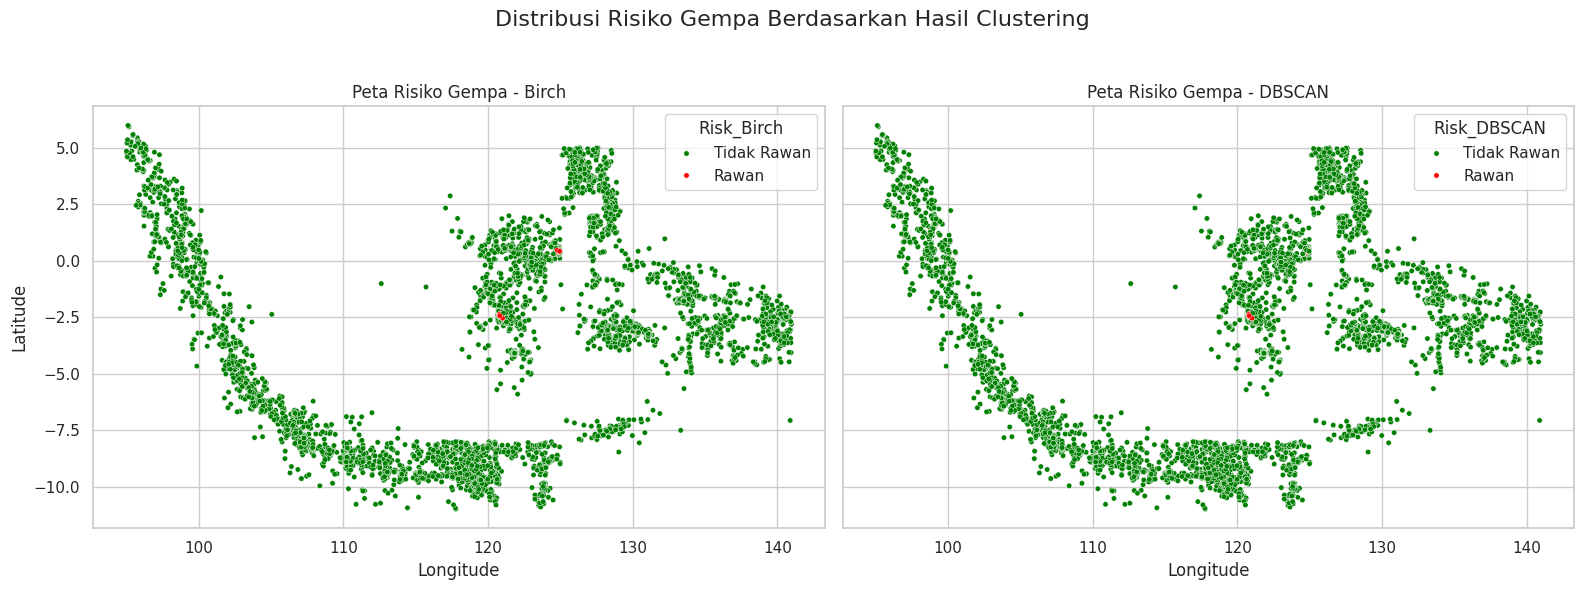

In [19]:
# Mapping visualisasi spasial (Longitude vs Latitude)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# Birch
sns.scatterplot(data=data, x='Longitude', y='Latitude', hue='Risk_Birch',
                palette={'Rawan': 'red', 'Tidak Rawan': 'green'}, s=15, ax=axes[0])
axes[0].set_title("Peta Risiko Gempa - Birch")
axes[0].grid(True)

# DBSCAN — tanpa filter noise
sns.scatterplot(data=data, x='Longitude', y='Latitude', hue='Risk_DBSCAN',
                palette={'Rawan': 'red', 'Tidak Rawan': 'green'}, s=15, ax=axes[1])
axes[1].set_title("Peta Risiko Gempa - DBSCAN")
axes[1].grid(True)

plt.suptitle("Distribusi Risiko Gempa Berdasarkan Hasil Clustering", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()